# Summary

Solve for a time-invariant or "steady-state" profile.

This is achieved by first integrating Hamilton's equations along an erosion ray trajectory initiated at a constant velocity "normal fault" boundary. Copies of this ray are then placed at uniformly spaced (vertically downwards) intervals along the boundary, generating a staggered time-sequence of rays whose ensemble positions at an appropriately chosen time slice constitute a time-invariant profile.

Visualization of the ray ensemble is carried out, along with graphing of properties of the time-invariant profile across the model domain. Comparison is made with the "steady-state" profile derived by integrating the model erosion equation directly (via a polynomial in $\mathrm{d}z/\mathrm{d}x$).

### Preliminaries

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta1p5_ratio0p5_xiv8']
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta1p5_ratio0p5_xiv10']
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta1p5_ratio0p5_xiv30']
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta1p5_ratio0p5_xiv60']
    
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta0p5_ratio0p5_xiv30']
#     pr_filenames = ['TimeInvariant_sinbeta_ramp_eta0p5_ratio0p5_xiv80']
    
    pr_filenames = ['TimeInvariant_eta0p5_beta04']
    
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import simplify, Matrix, Eq, Rational, \
                    factor, poly, solve
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d, convert, omitdict, round as gmround
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations, EquationSubset, gradient_value
from gme.ode_raytracing import TimeInvariantSolution
from gme.plot import TimeInvariantPlots

# Import units & dimensions
from sympy.physics.units \
    import Quantity, Dimension, \
            length, speed, velocity, time, \
            km, cm, mm, meter, meters, \
            convert_to, percent, degrees, radians
from sympy.physics.units.systems import SI

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','RayTracing')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/RayTracing',
 ['TimeInvariant_eta0p5_beta04'])

In [2]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'TimeInvariantSolutions',
    'short_name': 'tis',
    'subtitle': '',
    'title': 'Time-invariant profile solution: ramp, eta=1/2, sin(beta) model',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    't_xiv0_list': None,
    'varepsilon': 100,
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': None}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'DOP853', 'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.0115,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 30,
    'spline_order': 3,
    't_isochrone_max

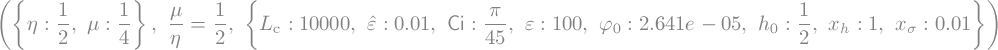

In [3]:
# Create a dict of the key physics parameters to be used in substitutions
subexp = {
    eta: pr.model.eta,
    mu: pr.model.mu
}
sub = {
    Ci: pr.model.Ci, 
    Lc: pr.model.Lc, 
#     x_1: pr.model.x_1, 
#     xiv_0: pr.model.xiv_0, 
    varepsilon: pr.model.varepsilon, 
    varepsilonhat: pr.model.varepsilon/pr.model.Lc, 
    varphi_0: pr.model.varphi_0,
    h_0: pr.model.h_0,
    x_sigma: pr.model.x_sigma,
    x_h: pr.model.x_h
}
subexp, Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Equations

Derive the GME equation set (using SymPy) for a specific erosion model.

In [4]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=pr.plot.do_huygens_wavelets | pr.plot.do_ray_conjugacy,
                  parameters=sub, do_raw=True )

# Integration

Integrate Hamilton's equations in $(\mathbf{r}, \mathbf{\widetilde{p}})[t]$ for a given vertical component of the erosion rate (initial condition) equivalent to a constant vertical velocity (boundary condition). In other words, given a value for vertical slip rate $\xi^{\downarrow}$ at the boundary at $x=0$, where the initial ray position is $\left.(r^x, r^z)\right|_{t=0} = (0,0)$, specify the initial value of the vertical component of the normal-slowness covector $p_z[t=0] = \left.-1/\xi^{\downarrow}\right|_{x=0}$.  The horizontal component of the initial covector $p_x[t=0]$ is computed by calculating the surface gradient $\left.\tan\beta\right|_{x=0}$ from the erosion model and then using $-p_x/p_z = \tan\beta$.

Various ODE quadrature methods provided by SciPy's `solve_ivp` function can be used here:
"DOP853" (explicit Runge-Kutta method of order 8(5,3)  with dense output of order 7); basic Runge-Kutta (RK45 or RK23); "Radau" (implicit Runge-Kutta method of the Radau IIA family of order 5); "BDF" (implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation); "LSODA" (Adams/BDF method with automatic stiffness detection and switching). "Radau" is by far the most accurate (in terms of computing surface gradient); "DOP853" is less accurate, but its computation of vertical erosion rate is quite robust. "BDF" computes gradient a bit better, but its vertical erosion rate is less accurate. All quadrature methods have very similar timings.


Test timings and notes for `TimeInvariant_tanbeta_rampflat_eta1p0_xiv25_xh0p9`:
  - DOP853:  335ms
      - ~1% errors in relative gradient, minor error in vertical erosion rate
  - Radau:   340ms
      - better than ~0.1% errors in relative gradient, **robust** vertical erosion rate
  - RK45:   330ms
      - ~1.5% errors in relative gradient,  moderate error in vertical erosion rate
  - RK23:   330ms
      - ~1.5% errors in relative gradient,  moderate error in vertical erosion rate
  - BDF:   345ms
      - ~0.3% errors in relative gradient, moderate error in vertical erosion rate
  - LSODA:   335ms
      - ~1% errors in relative gradient, moderate error in vertical erosion rate

In [5]:
pr.model.beta_0 = float(beta_0.subs(e2d(gmeq.beta0_Ci_eqn.subs(omitdict(sub,[beta_0])).subs(subexp))))
sub.update({beta_0:pr.model.beta_0})
convert(Eq(beta_0, pr.model.beta_0), n=2, units=degrees, do_raw=False)

In [6]:
pr.model.xiv_0 = float( xiv_0.subs(e2d(gmeq.xiv0_eqn.subs(omitdict(sub,[xiv_0])).subs(subexp))) )
pr.model.xih_0 = float( xih_0.subs(e2d(gmeq.xih0_eqn.subs(omitdict(sub,[xih_0])).subs(subexp))) )
sub.update({xiv_0:pr.model.xiv_0, xih_0:pr.model.xih_0})
pr.model.xiv_0, pr.model.xih_0, (pr.model.xiv_0/pr.model.xih_0, sy.tan(pr.model.beta_0))

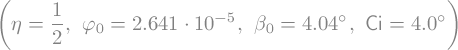

In [7]:
(
    Eq(eta,pr.model.eta), 
    Eq(varphi_0,pr.model.varphi_0),
    convert(Eq(beta_0,pr.model.beta_0), n=2, units=degrees, do_raw=False), 
    convert( gmeq.Ci_beta0_eqn.subs(omitdict(sub,[Ci])).subs(subexp).subs({beta_0:pr.model.beta_0}), 
                n=2, units=degrees, do_raw=False),
#     convert(simplify( gmeq.Ci_xih0_eqn
#          .subs(e2d(gmeq.xih0_xiv0_eqn))
#          .subs({eta:pr.model.eta}).subs(sub) ).subs({beta_0:beta0_}),
#                 n=2, units=degrees, do_raw=False)
)

In [8]:
(
    convert(
        gmeq.Ci_xih0_eqn.subs({Lc:1e4, mu:pr.model.mu, 
                               eta:pr.model.eta, xih_0:1e-2, varphi_0:1.321e-5}),
        n=3, units=degrees, do_raw=False),
    convert(
        gmeq.Ci_xih0_eqn.subs({Lc:1e4, mu:pr.model.mu, 
                               eta:pr.model.eta, xih_0:1e-2, varphi_0:2.641e-5}),
        n=3, units=degrees, do_raw=False)
)

In [9]:
# px0_poly_eqn = sy.poly(gmeq.poly_px_xiv0_eqn.subs(sub).subs({rx:0,mu:pr.model.mu}))
# beta0_ = np.arctan( gradient_value(0, -1/pr.model.xiv_0, px0_poly_eqn) )
# convert(Eq(beta_0,beta0_), n=2, units=degrees, do_raw=False)

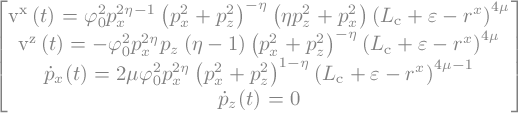

In [10]:
gmeq.hamiltons_eqns

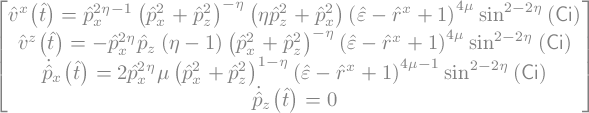

In [11]:
gmeq.hamiltons_ndim_eqns

In [12]:
# varphi_ = gmeq.varphi_rx_eqn.rhs
# rdotx_simple = (simplify( gmeq.hamiltons_eqns[0].rhs/varphi_**2 )*gmeq.varphi_rx_eqn.lhs**2)
# rdotz_simple = (simplify( gmeq.hamiltons_eqns[1].rhs/varphi_**2 )*gmeq.varphi_rx_eqn.lhs**2)
# pdotx_simple = (simplify( gmeq.hamiltons_eqns[2].rhs/varphi_ )*gmeq.varphi_rx_eqn.lhs)
# pdotz_simple = (simplify( gmeq.hamiltons_eqns[3].rhs/varphi_ )*gmeq.varphi_rx_eqn.lhs)
# ( gmeq.varphi_rx_eqn.subs(subexp), gmeq.hamiltons_eqns.subs(subexp), 
#   Matrix( (rdotx_simple,rdotz_simple,pdotx_simple,pdotz_simple) ).subs(subexp))

Create an instance of the ODE solution object.

In [39]:
gmeq.define_Hamiltons_eqns()
gmeq.nondimensionalize()
gmeq.define_nodimensionalized_Hamiltons_eqns()
gmeq.define_px_poly_eqn(eta_choice=pr.model.eta, do_ndim=True)

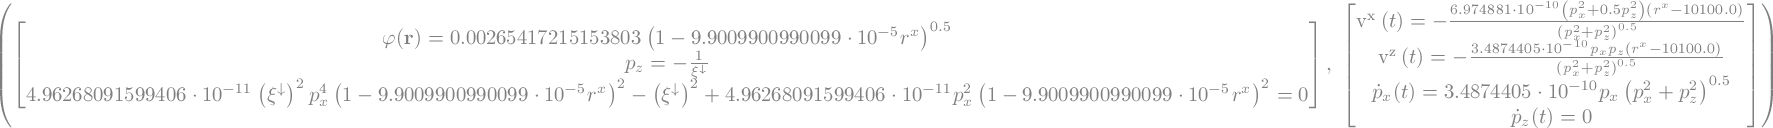

In [40]:
gmeq_subset = EquationSubset(gmeq, sub, do_ndim=False) 
Matrix([
    gmeq_subset.varphi_rx_eqn, 
    gmeq_subset.pz_xiv_eqn,
    gmeq_subset.poly_px_xiv_eqn,
     #gmeq.geodesic_eqns
#  gmeq.px_initial_eqn, gmeq.pz_initial_eqn
]), Matrix([simplify(gmeq_subset.hamiltons_eqns)])

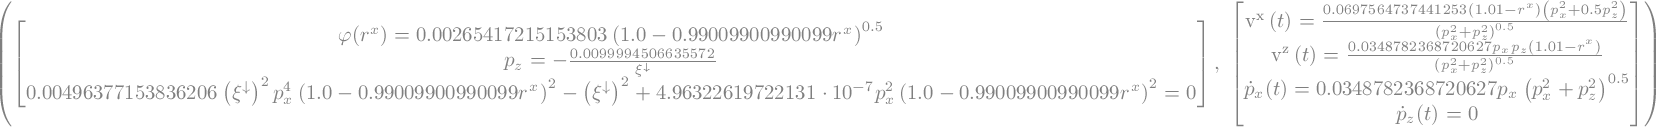

In [48]:
gmeq_ndim_subset = EquationSubset(gmeq, sub, do_ndim=True) 
Matrix([
    gmeq_ndim_subset.varphi_rx_eqn, 
    gmeq_ndim_subset.pz_xiv_eqn,
    gmeq_ndim_subset.poly_px_xiv_eqn,
     #gmeq.geodesic_eqns
#  gmeq.px_initial_eqn, gmeq.pz_initial_eqn
]), Matrix([gmeq_ndim_subset.hamiltons_eqns])

In [42]:
(2*mu*(Ci)**(2*(1-eta))).subs(sub).subs(subexp).n(), xih_0.subs(sub)

In [54]:
# pr.solve.t_end = 0.035
# pr.solve.t_end
pr.solve.t_end = 0.02*1e4
# pr.solve.t_end = 0.06*1e8

In [92]:
modsub = sub.copy()
# modsub[xiv_0] = sub[xiv_0]/sub[xih_0] #sy.tan(beta_0).subs(sub)
# modsub[xih_0] = 1 #sy.tan(beta_0).subs(sub)
# modsub

In [93]:
gmes = TimeInvariantSolution( gmeq_ndim_subset, parameters=modsub, 
                              t_end=pr.solve.t_end, t_distribn=pr.solve.t_distribn, 
                              xhat_stop=1,
                              n_t=pr.solve.ray_n_t,
                              choice=pr.solve.choice, 
                              method=pr.solve.method[pr.solve.choice],
                              do_dense=pr.solve.do_dense )

Solve Hamilton's ODEs using DOP853 method of integration


Set of initial conditions for the ray.

In [94]:
gmes.initial_conditions()

In [95]:
Matrix([gmes.parameters])

Show the form of the ray tracing Hamilton's equations given the model parameters.

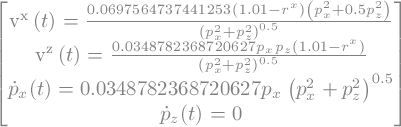

In [96]:
gmes.gmeq.hamiltons_eqns

Perform integration of the coupled ODEs.

In [97]:
gmes.solve()
print('Message: {}\nSuccess? {}\nStatus: {}\nt_final: {}\nrx_final: {}'
      .format(gmes.solns[0].message, gmes.solns[0].success,
              gmes.solns[0].status, gmes.solns[0].t[-1], gmes.solns[0].y[0][-1]) )

Message: Required step size is less than spacing between numbers.
Success? False
Status: -1
t_final: 6.722222222222224
rx_final: 1.0099547436932153


Process the above output, which takes the form of time series of positions $\{\mathbf{r}\}$ and front normal slownesses  $\{\mathbf{\widetilde{p}}\}$, into various arrays.

In [98]:
gmes.postprocessing(spline_order=pr.resolve.spline_order)

In [99]:
gmes.more_postprocessing(spline_order=pr.resolve.spline_order, extrapolation_mode=1)

Generate a time-invariant profile by spatially integrating the topographic gradients implied by the time series of front normal slownesses  $\{\mathbf{\widetilde{p}}\}$. 

This profile can alternatively be generated by synthesizing a staggered sequence of rays and gathering all the ray positions $\{\mathbf{r}\}$ for a chosen time slice. This has already been done in the post-processing step.

In [110]:
gmes.integrate_h_profile(do_truncate=True, x_max=float(1-varepsilonhat.subs(sub)))

# Plots

Visualization of results

## Preliminaries

In [101]:
gr = TimeInvariantPlots()

In [102]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = f'_eta{float(sy.N(gmeq.eta))}'
suffix += f'_ratio{float(sy.N(gmeq.mu/gmeq.eta))}' if gmeq.mu!=Rational(1,2) else ''
suffix += f'_xiv{float(sy.N(gmes.parameters[xiv_0])):1.0f}'
suffix = (suffix if pr.model.varphi_type=='ramp' \
            else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix
job_name

'tis_sinbeta_ramp_eta0p5_ratio0p5_xiv0'

## Results

Graph a selection of staggered ray solutions (colorized lines with arrows) along with the time-invariant solution solved for in two ways (gathering of staggered ray termini or integration of gradients along a ray).

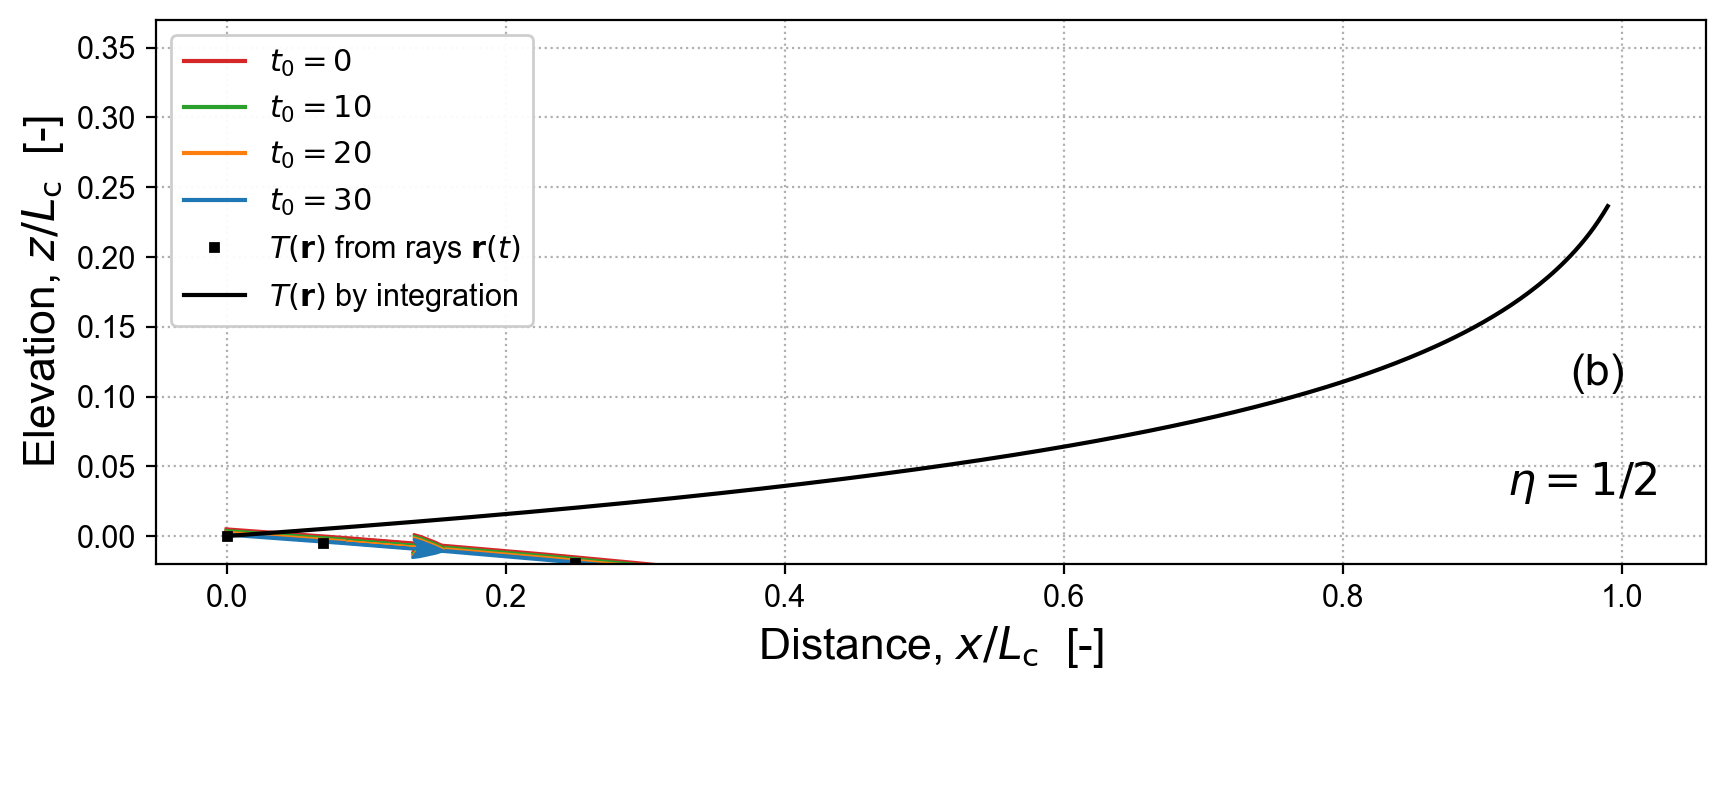

In [111]:
gr.profile_h_rays( gmes, gmeq, modsub, job_name+'_h_rays', fig_size=(10,7), 
                   y_limits=pr.plot.ray_y_limits, 
                   eta_label_xy=pr.plot.ray_eta_xy, 
                   n_points=pr.plot.rays_n_points,
                   n_rays=pr.plot.n_rays,
                   profile_subsetting=pr.plot.profile_subsetting, 
                   do_pub_label=pr.plot.do_pub_labeling, 
                   pub_label=pr.plot.pub_labels['profile_h_rays'],
                   pub_label_posn=pr.plot.pub_label_posns['profile_h_rays'] )

In [104]:
if pr.plot.do_profile_extra:
    gr.profile_h_rays( gmes, gmeq, sub, job_name+'_h_rays_extra', fig_size=(10,7), 
                       ray_subsetting=pr.plot.ray_subsetting, n_points=pr.plot.rays_n_points,
                       do_simple=True )

Graph the behavior of $\mathbf{r}$, $\mathbf{v}$, and  $\mathbf{\widetilde{p}}$ along a time-invariant profile, along with a measure of $\mathbf{v},\mathbf{\widetilde{p}}$ anisotropy.

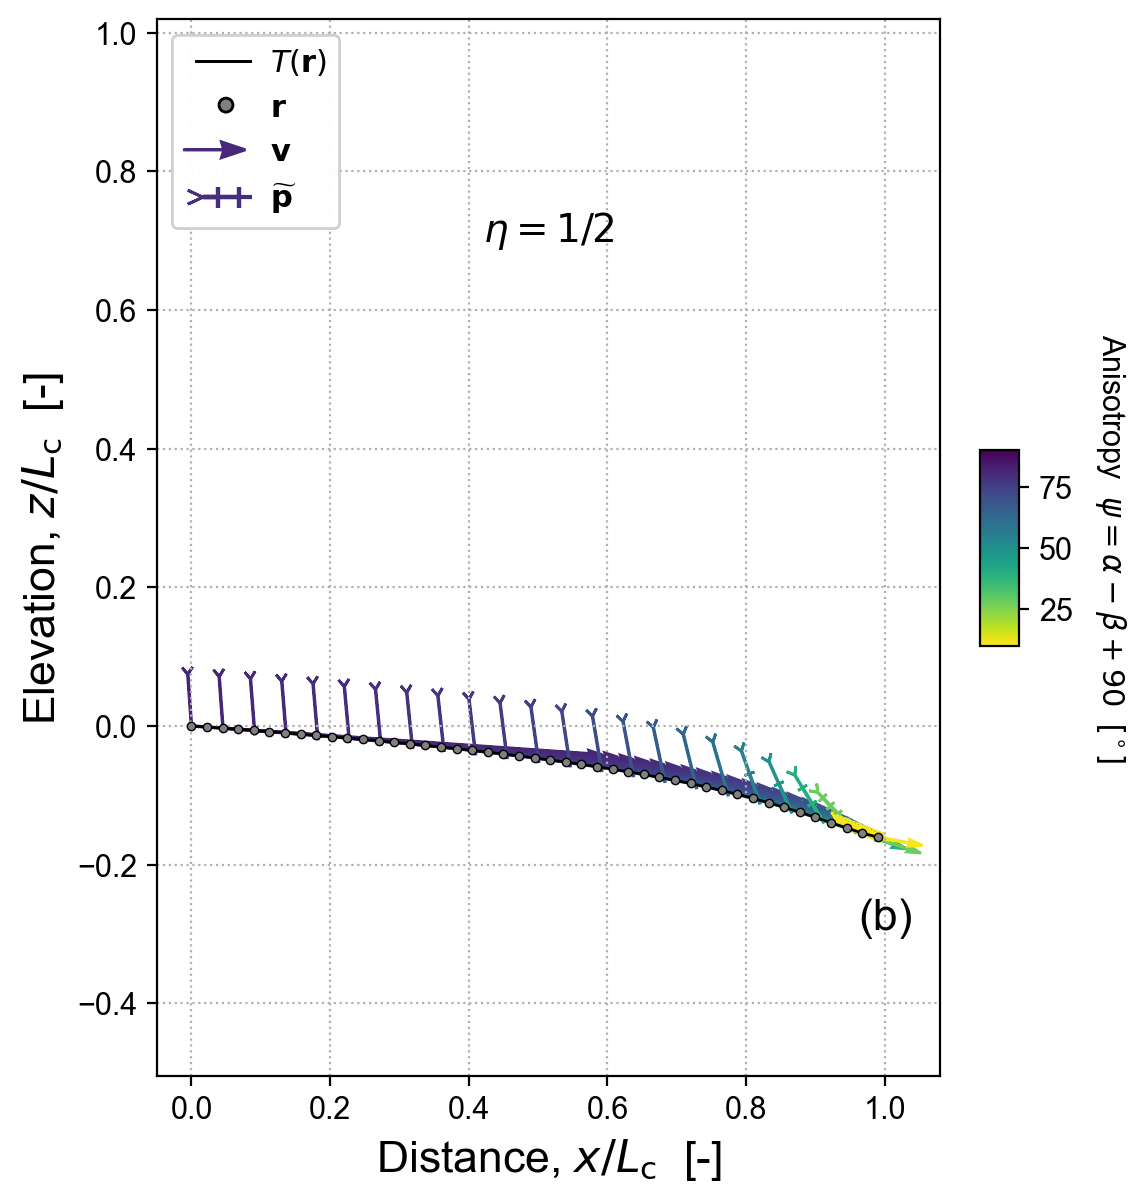

In [112]:
gr.profile_aniso( gmes, gmeq, modsub, job_name+'_aniso', fig_size=(10,7), 
#                   y_limits=pr.plot.aniso_y_limits, 
                   xf_stop=float(1-varepsilonhat.subs(sub)),
                   n_points=pr.plot.aniso_n_points, n_arrows=(pr.plot.aniso_n_points+1)//2, 
                   v_exponent=pr.plot.aniso_arrow_exponent, v_scale=pr.plot.aniso_arrow_size, 
                   do_pub_label=pr.plot.do_pub_labeling, 
                   pub_label=pr.plot.pub_labels['profile_aniso'])

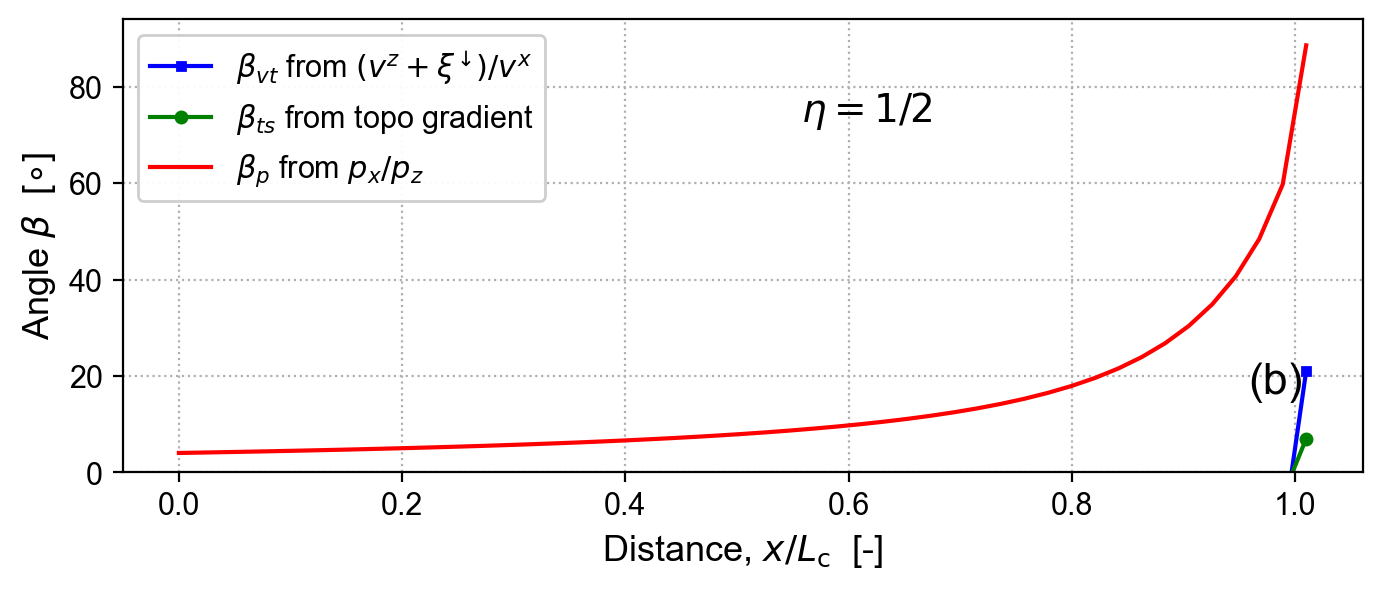

In [106]:
gr.profile_beta( gmes, gmeq, modsub, job_name+'_beta', fig_size=(8,3), n_points=25,
                 do_pub_label=pr.plot.do_pub_labeling, 
                 pub_label=pr.plot.pub_labels['profile_beta'],
                 pub_label_posn=pr.plot.pub_label_posns['profile_beta'] )

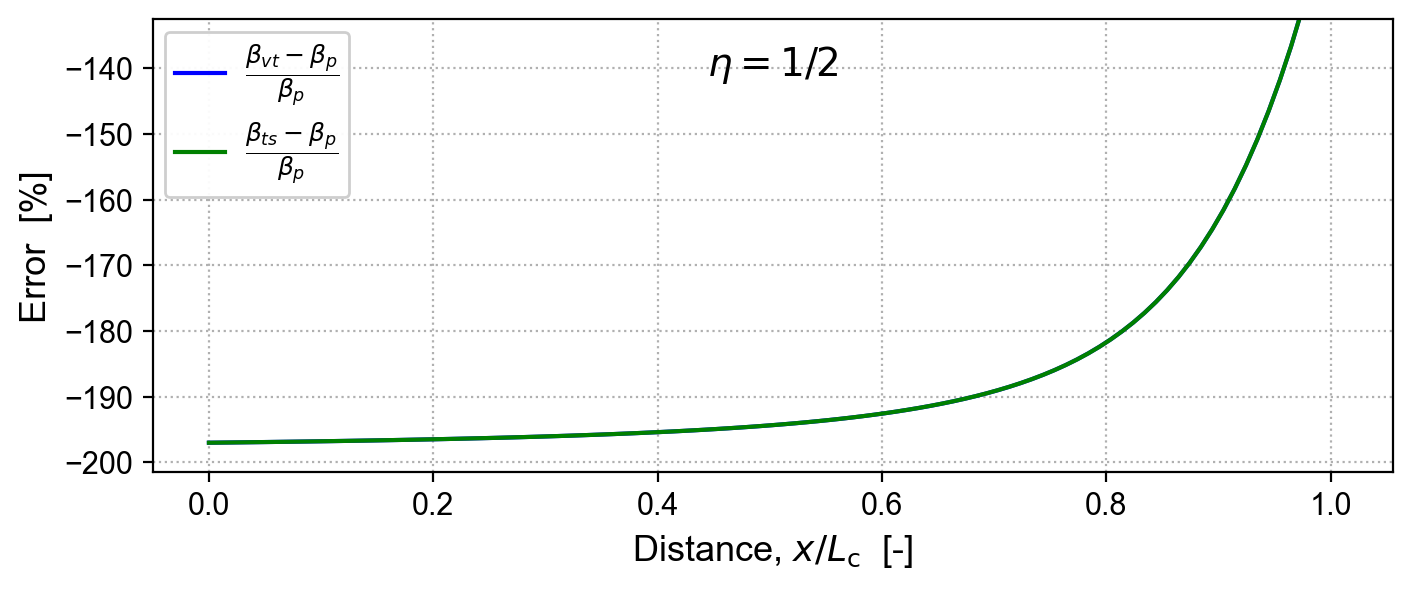

In [69]:
gr.profile_beta_error( gmes, gmeq, sub, job_name+'_beta_error', fig_size=(8,3), 
                       n_points=pr.plot.profile_n_points )

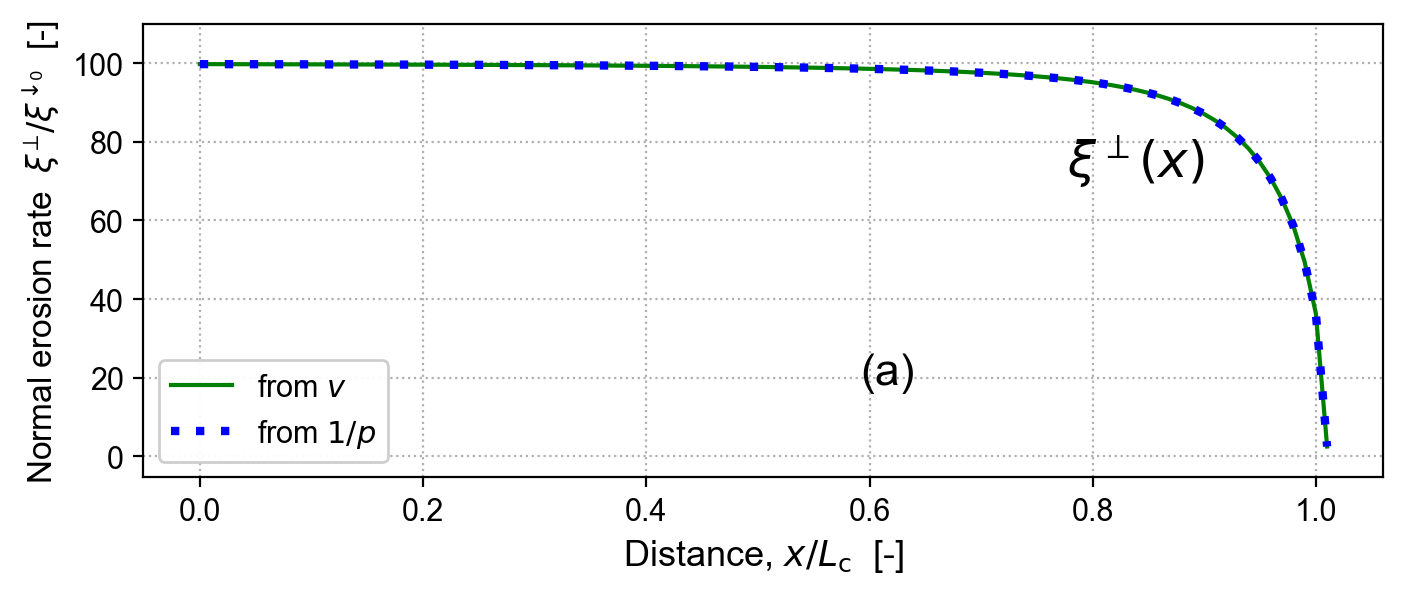

In [70]:
gr.profile_xi( gmes, gmeq, sub, job_name+'_xi', fig_size=(8,3), 
               n_points=pr.plot.profile_n_points, xi_norm=xiv_0.subs(sub), 
               do_pub_label=pr.plot.do_pub_labeling,
               pub_label=pr.plot.pub_labels['profile_xi'] )

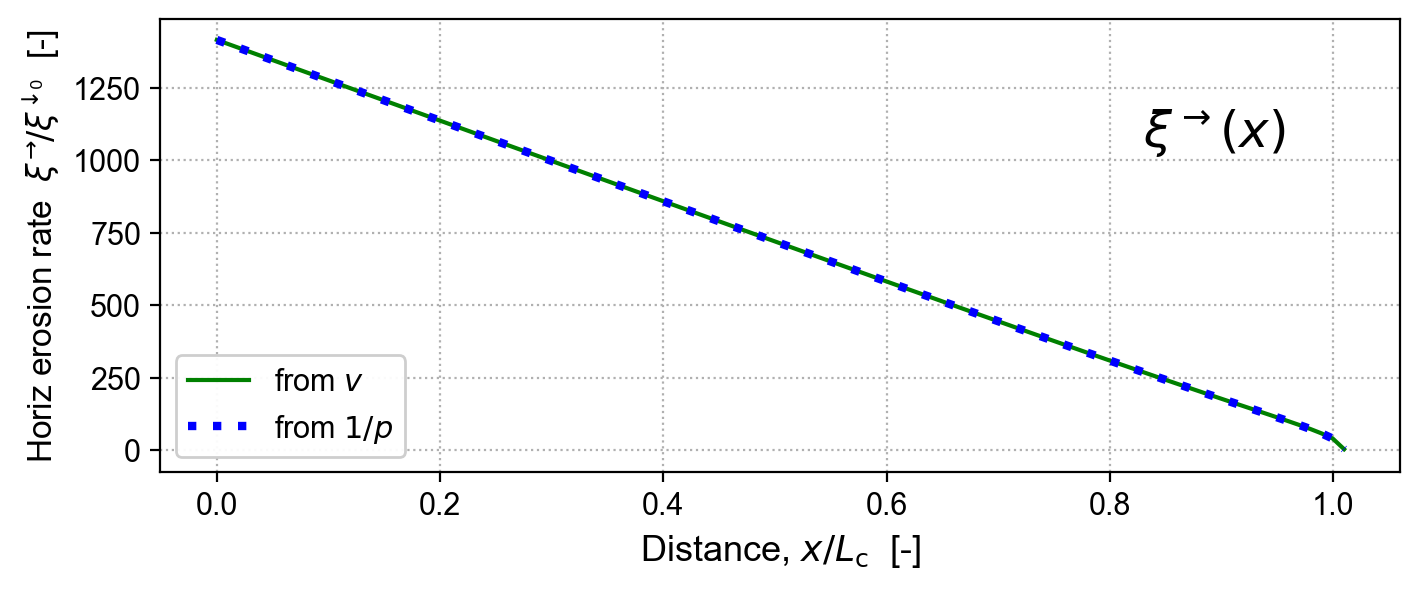

In [71]:
gr.profile_xihorizontal( gmes, gmeq, sub, job_name+'_xihorizontal', fig_size=(8,3), 
                         n_points=pr.plot.profile_n_points, 
                         xi_norm=xiv_0.subs(sub), 
                         do_pub_label=pr.plot.do_pub_labeling,
                         pub_label=pr.plot.pub_labels['profile_xihorizontal'] )

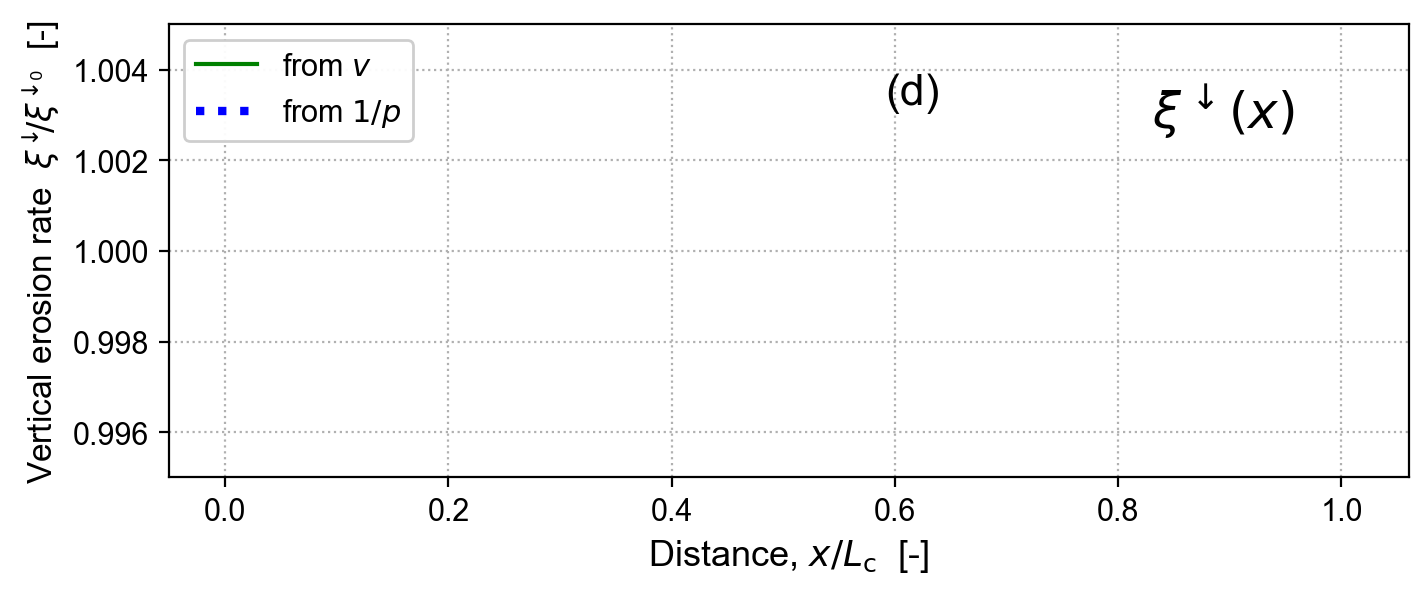

In [72]:
gr.profile_xivertical( gmes, gmeq, sub, job_name+'_xivertical', fig_size=(8,3), 
                       n_points=pr.plot.profile_n_points, y_limits=[0.995,1.005],
                       xi_norm=xiv_0.subs(sub), 
                       do_pub_label=pr.plot.do_pub_labeling, 
                       pub_label=pr.plot.pub_labels['profile_xivertical'] )

# Save

Export the graphs as PNG and/or PDF image files.

In [36]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/TimeInvariantSolutions"
Exported "tis_sinbeta_ramp_eta0p5_ratio0p5_xiv0_h_rays.png"
Exported "tis_sinbeta_ramp_eta0p5_ratio0p5_xiv0_aniso.png"
Exported "tis_sinbeta_ramp_eta0p5_ratio0p5_xiv0_beta.png"
Exported "tis_sinbeta_ramp_eta0p5_ratio0p5_xiv0_beta_error.png"
Exported "tis_sinbeta_ramp_eta0p5_ratio0p5_xiv0_xi.png"
Exported "tis_sinbeta_ramp_eta0p5_ratio0p5_xiv0_xihorizontal.png"
Exported "tis_sinbeta_ramp_eta0p5_ratio0p5_xiv0_xivertical.png"
